In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import Inception_V3_Weights
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.Resize(299), # Resize to 299x299 for Inception
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


In [ ]:
inception = models.inception_v3(weights=Inception_V3_Weights.DEFAULT, aux_logits=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 82.6MB/s]


In [ ]:
# Freeze all layers (optional)
for param in inception.parameters():
    param.requires_grad = False

# Replace main classifier (2048 → 10)
inception.fc = nn.Linear(in_features=2048, out_features=10)

# Replace auxiliary classifier (768 → 10)
inception.AuxLogits.fc = nn.Linear(in_features=768, out_features=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception = inception.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inception.fc.parameters(), lr=0.001)  # Only training final layer

In [ ]:
inception.train()

for epoch in range(10):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Inception returns (main_output, aux_output) during training
        outputs, aux_outputs = inception(inputs)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2  # Combine both losses

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            running_loss = 0.0
    print(f"Epoch:{epoch + 1}, loss: {running_loss / 100:.3f}")

print("Training complete")

Epoch:1, loss: 1.507
Epoch:2, loss: 1.487
Epoch:3, loss: 1.482
Epoch:4, loss: 1.471
Epoch:5, loss: 1.480
Epoch:6, loss: 1.515
Epoch:7, loss: 1.512
Epoch:8, loss: 1.484
Epoch:9, loss: 1.503
Epoch:10, loss: 1.495
Training complete


In [ ]:
inception.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = inception(images)
        if isinstance(outputs, tuple):  # just in case
            outputs = outputs[0]
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 76.69%


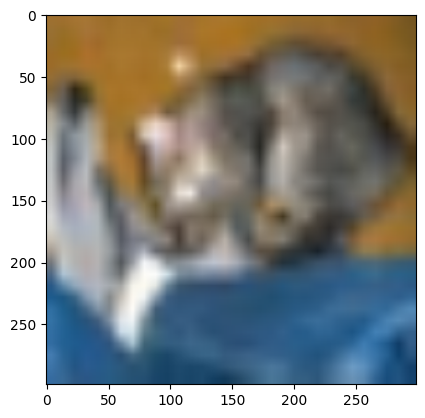

Predicted: cat, Actual: cat


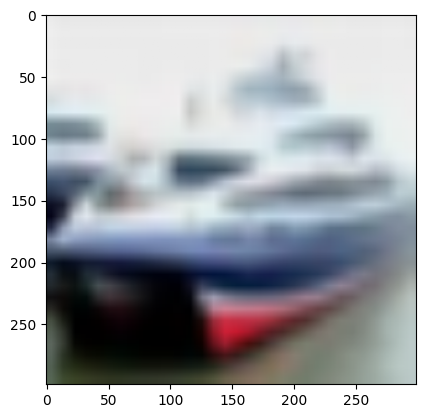

Predicted: ship, Actual: ship


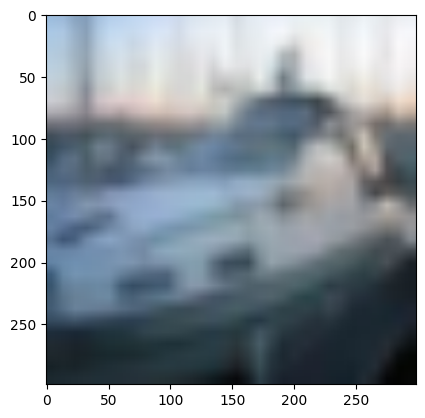

Predicted: ship, Actual: ship


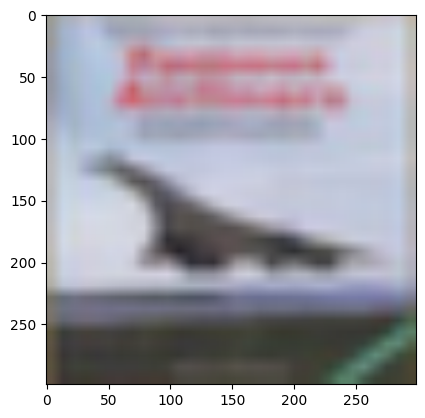

Predicted: bird, Actual: plane


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)
outputs = inception(images.to(device))
if isinstance(outputs, tuple):
    outputs = outputs[0]
_, predicted = torch.max(outputs, 1)

for i in range(4):
    imshow(images[i])
    print(f"Predicted: {classes[predicted[i]]}, Actual: {classes[labels[i]]}")